<a id="top"></a>
# Classification Tutorial

## Prerequisites

This tutorial requires the following:
- All files are present and in the following directory structure:
    - **tutorial_classification_sample.ipynb** - This Jupyter* Notebook
    - **squeezenet1.1/squeezenet1.1.bin and squeezenet1.1/squeezenet1.1.xml** - The IR files for the inference model created using Model Optimizer
    - **squeezenet1.1/squeezenet1.1.labels.txt** - Mapping of numerical labels to text strings
    - **dog.jpg** - Test image
    - **cat.jpg** - Test image
    - **bird.jpg** - Test image
    - **doc_*.png** - Images used in the documentation
- Optional: URL to user's image to run inference on

<br><div class="alert alert-warning" style="color:black"><i>
<b>Note: </b>It is assumed that the server this tutorial is being run on has JupyterLab*, the Intel® Distribution of OpenVINO™ toolkit, and other required libraries already installed.  If you download or copy to a new server, this tutorial may not run.  Prerequisites and setup instructions may be found [here](../README.md).</i></div> 


## Introduction

The purpose of this tutorial is to examine a sample application that was created using the [Intel® Distribution of Open Visual Inference & Neural Network Optimization (OpenVINO™) toolkit](https://software.intel.com/openvino-toolkit).  This tutorial will go step-by-step through the necessary steps to demonstrate object classification on images and batches of images.  Classification is performed using a pre-trained network and running it using the Intel® Distribution of OpenVINO™ toolkit Inference Engine.  Inference will be executed using the same CPU(s) running this Jupyter* Notebook.

The pre-trained model to be used for object detection is the ["squeezenet1.1"](https://github.com/DeepScale/SqueezeNet/) which has already been converted to the necessary Intermediate Representation (IR) files needed by the Inference Engine (Conversion is not covered here, please see the [Intel® Distribution of OpenVINO™ toolkit](https://software.intel.com/openvino-toolkit) documentation for more details).  The model is capable of classifying and reporting the probability of 1000 different objects including different species of cats, dogs, birds, insects, etc. (see `squeezenet1.1/squeezenet1.1.labels.txt` file for complete list).  

### Key concepts

Before going into the samples in the tutorial steps, first we will go over some key concepts that will be covered in this tutorial.

#### Intel® distribution of OpenVINO™ toolkit overview and terminology

Let us begin with a brief overview of the Intel® Distribution of OpenVINO™ toolkit and what this tutorial will be covering.  The Intel® Distribution of OpenVINO™ toolkit enables the quick deployment of convolutional neural networks (CNN) for heterogeneous execution on Intel® hardware while maximizing performance. This is done using the Intel® Deep Learning Deployment Toolkit (Intel® DLDT) included within the Intel® Distribution of OpenVINO™ toolkit with its main components shown below.

![image alt text](./doc_openvino_overview_image.png)

The basic flow is:

1. Use a tool, such as Caffe*, to create and train a CNN inference model

2. Run the created model through Model Optimizer to produce an optimized Intermediate Representation (IR) stored in files (`.bin` and `.xml`) for use with the Inference Engine

3. The User Application then loads and runs models on devices using the Inference Engine and the IR files  

This tutorial will focus on the last step, the User Application and using the Inference Engine to run a model on a CPU.

##### Using the inference engine

Below is a more detailed view of the User Application and Inference Engine:

![image alt text](./doc_inference_engine_image.png)

The Inference Engine includes a plugin library for each supported device that has been optimized for the Intel® hardware device CPU, GPU, and VPU.  From here, we will use the terms "device" and “plugin” with the assumption that one infers the other (e.g. CPU device infers the CPU plugin and vice versa).  As part of loading the model, the User Application tells the Inference Engine which device to target which in turn loads the associated plugin library to later run on the associated device. The Inference Engine uses “blobs” for all data exchanges, basically arrays in memory arranged according the input and output data of the model.

###### Inference engine API integration flow

Using the inference engine API follows the basic steps outlined briefly below.  The API objects and functions will be seen later in the sample code.

1. Load the plugin

2. Read the model IR

3. Load the model into the plugin

6. Prepare the input

7. Run inference

8. Process the output

More details on the Inference Engine can be found in the [Inference Engine Development Guide](https://docs.openvinotoolkit.org/latest/_docs_IE_DG_Deep_Learning_Inference_Engine_DevGuide.html)

### Input preprocessing

Often, the dimensions of the input data does not match the required dimensions of the input data for the inference model.  A common example is an input video frame.  Before the image may be input to the inference model, the input must be preprocessed to match the required dimensions for the inference model as well as channels (i.e. colors) and batch size (number of images present).  The basic step performed is to resize the frame from the source dimensions to match the required dimensions of the inference model’s input, reorganizing any dimensions as needed.

This tutorial and the many samples in the Intel® Distribution of OpenVINO™ toolkit use OpenCV to perform resizing of input data.  The basic steps performed using OpenCV are:

1.  Resize image dimensions form image to model's input W x H:<br>
`    frame = cv2.resize(image, (w, h))`
   
2. Change data layout from (H x W x C) to (C x H x W)<br>
`    frame = frame.transpose((2, 0, 1))`  

3. Reshape to match input dimensions<br>
`    frame = frame.reshape((n, c, h, w))`

### Batch size
Batch size refers to the number of input data to be inferred during a single inference run through the Inference Engine.  Things to be aware of the batch size for an inference model:

#### Batch size and its effects on input and output data is model dependent

* The output batch size may scale with input batch size.  For example, the classification model used in this tutorial will have one output for each input.

* The output may contain results across all batched inputs.  For example, the object detection model used in 
the **Jupyter Notebook Object Detection Sample Tutorial** gives one set of outputs regardless of input batch size, with each output indicating to which input the results belong.

#### How batch size is set

* The default setting is located in the model’s IR which is set either by:

   * The [Model Optimizer](https://docs.openvinotoolkit.org/latest/_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html) command line option when creating the IR files

   * Or from the original source (e.g. Caffe) in which can be read using the Inference Engine API 

* Batch size may be set explicitly using the Inference Engine API setting *batch_size* field of the created IENetwork object.  Later in the [Inferring Input Images in Batches](#Inferring-Input-Images-in-Batches) section of this tutorial, converting from a single input image to a batch of input images will be shown to highlight the differences.

### Performance counters

During inference execution, performance counts (metrics) are kept per layer.  Included with the counts, are the time spent and the "execution type" that indicates which device the layer was executed.  The performance counts may be retrieved from an internal request object after inference has completed and calling `get_perf_counts()`.  An example is shown in the [Report Performance counters](#Report-Performance-Counters) step of this tutorial.

## Sample application

The following sections will guide you through a sample application

### Imports

We begin by importing all of the Python* modules that will be used by the sample code:
- [os](https://docs.python.org/3/library/os.html#module-os) - Operating system specific module (used for file name parsing)
- [cv2](https://docs.opencv.org/trunk/) - OpenCV module
- [time](https://docs.python.org/3/library/time.html#module-time) - time tracking module (used for measuring execution time)
- [numpy](http://www.numpy.org/) - n-dimensional array manipulation
- [openvino.inference_engine](https://software.intel.com/en-us/articles/OpenVINO-InferEngine) - the IECore object
- [matplotlib](https://matplotlib.org/) - pyplot is used for displaying output images

Run the cell below to import Python dependencies needed for displaying the results in this notebook. 
<br><div class="alert alert-info" style="color: black"><b>Tip: </b>Select a cell and then use **Ctrl+Enter** to run that cell.</div>

In [1]:
import os
import cv2
import time
import numpy as np
from openvino.inference_engine import IECore
%matplotlib inline
from matplotlib import pyplot as plt
print('Imported Python modules successfully.')

Imported Python modules successfully.


### Configuration
Here we will create and set the following configuration parameters used by the sample:  
* **model_xml** - Path to the .xml IR file of the trained model to use for inference
* **model_bin** - Path to the .bin IR file of the trained model to use for inference (derived from *model_xml*)
* **input_path** - Path to input image
* **device** - Specify the target device to infer on,  CPU, GPU, FPGA, or MYRIAD is acceptable, however the device must be present.  For this tutorial we use "CPU" which is known to be present.
* **report_top_n** - Number of top-n classification results to report
* **labels_path** - Path to labels mapping file used to map outputted integers to strings (e.g. 7="car")

We will set all parameters here only once except for *input_path* which we will change later to point to different images.

In [2]:
# model IR files
model_xml = "./squeezenet1.1/squeezenet1.1.xml"
model_bin = "./squeezenet1.1/squeezenet1.1.bin"

# input image file
input_path = "./dog.jpg"
   
# device to use
device = "CPU"

# number of top results to display
report_top_n = 10

# output labels 
labels_path = "./squeezenet1.1/squeezenet1.1.labels"

print("Configuration parameters settings:"
     "\n\tmodel_xml=", model_xml,
      "\n\tmodel_bin=", model_bin,
      "\n\tinput_path=", input_path,
      "\n\tdevice=", device, 
      "\n\tlabels_path=", labels_path, 
      "\n\treport_top_n=", report_top_n)

Configuration parameters settings:
	model_xml= ./squeezenet1.1/squeezenet1.1.xml 
	model_bin= ./squeezenet1.1/squeezenet1.1.bin 
	input_path= ./dog.jpg 
	device= CPU 
	labels_path= ./squeezenet1.1/squeezenet1.1.labels 
	report_top_n= 10


### Create inference engine instance

Next we create the Inference Engine instance to be used by our application.


In [3]:
# create Inference Engine instance
ie = IECore()
print("An Inference Engine object has been created")

An Inference Engine object has been created


### Read network

Here we use `IECore:read_network()` to read the model's IR files into the Inference Engine. After loading the model, we check to make sure that all the model's layers are supported by the plugin we will use. We also check to make sure that the model's input and output are as expected for later when we run inference.

In [4]:
# load network from IR files
net = ie.read_network(model=model_xml, weights=model_bin)
print("Loaded model IR files [",model_bin,"] and [", model_xml, "]\n")

# check to make sure that the plugin has support for all layers in the loaded model
supported_layers = ie.query_network(net,device)
not_supported_layers = [l for l in net.layers.keys() if l not in supported_layers]
if len(not_supported_layers) != 0:
    print("ERROR: Following layers are not supported by the plugin for specified",
          " device {}:\n {}".format(device, ', '.join(not_supported_layers)))
    assert 0 == 1, "ERROR: Missing support for all layers in the model," \
               + " cannot continue."

# check to make sue that the model's input and output are what is expected
assert len(net.input_info.keys()) == 1, \
    "ERROR: This sample supports only single input topologies"
assert len(net.outputs) == 1, \
    "ERROR: This sample supports only single output topologies"
print("SUCCESS: Model IR files have been loaded and verified")

Loaded model IR files [ ./squeezenet1.1/squeezenet1.1.bin ] and [ ./squeezenet1.1/squeezenet1.1.xml ]

SUCCESS: Model IR files have been loaded and verified


### Load model

Here we load the model network into the plugin so that we may run inference.  `exec_net` will be used later to actually run inference.  After loading, we store the names of the input (`input_blob`) and output (`output_blob`) blobs to use when accessing the input and output blobs of the model.  Lastly, we store the model's input dimensions into the following variables:
- `n` = input batch size
- `c` = number of input channels (here 1 channel per color R,G, and B)
- `h` = input height
- `w` = input width

In [5]:
exec_net = ie.load_network(network=net, num_requests=2, device_name=device)

# store name of input and output blobs
input_blob = next(iter(net.input_info))
output_blob = next(iter(net.outputs))

# read the input's dimensions: n=batch size, c=number of channels, h=height, w=width
n, c, h, w = net.input_info[input_blob].input_data.shape
print("Loaded model into Inference Engine for device:", device, 
      "\nModel input dimensions: n=",n,", c=",c,", h=",h,", w=",w)

Loaded model into Inference Engine for device: CPU 
Model input dimensions: n= 1 , c= 3 , h= 227 , w= 227


### Load labels

For each detected object, the output from the model will include an integer to indicate which type of trained object has been detected (e.g. daisy, bee, etc.). To translate the integer into a more readable text string, a label mapping file may be used. The label mapping file is simply a text file where the line number is used for the index into a lookup table to be used later while reporting detected objects.

Here, if the `labels_path` variable has been set to point to a label mapping file, we open the file and load the labels into the variable `labels_map`.

In [6]:
labels_map = None
# if labels points to a label mapping file, then load the file into labels_map
print(labels_path)
if os.path.isfile(labels_path):
    with open(labels_path, 'r') as f:
        labels_map = [x.split(sep=' ', maxsplit=1)[-1].strip() for x in f]
    print("Loaded label mapping file [",labels_path,"]")
else:
    print("No label mapping file has been loaded, only numbers will be used",
          " for detected object labels")

./squeezenet1.1/squeezenet1.1.labels
Loaded label mapping file [ ./squeezenet1.1/squeezenet1.1.labels ]


### Prepare input

Here we read and then prepare the input image by resizing and re-arranging its dimensions according to the model's input dimensions. We define the functions `loadInputImage()` and `resizeInputImage()` for the operations so that we may reuse them again later in the tutorial.

Loaded input image [ ./dog.jpg ], resolution= 3124.0 w x  4020.0 h
Resized input image from (4020, 3124) to (227, 227)
Input image:


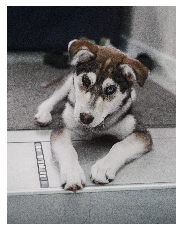

In [7]:
# define function to load an input image
def loadInputImage(input_path):
    # globals to store input width and height
    global input_w, input_h
    
    # use OpenCV to load the input image
    cap = cv2.VideoCapture(input_path) 
    
    # store input width and height
    input_w = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    input_h = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    print("Loaded input image [",input_path,"], resolution=", input_w, "w x ",
          input_h, "h")

    # load the input image
    ret, image = cap.read()
    del cap
    return image

# define function for resizing input image
def resizeInputImage(image):
    # resize image dimensions form image to model's input w x h
    in_frame = cv2.resize(image, (w, h))
    # Change data layout from HWC to CHW
    in_frame = in_frame.transpose((2, 0, 1))  
    # reshape to input dimensions
    in_frame = in_frame.reshape((n, c, h, w))
    print("Resized input image from {} to {}".format(image.shape[:-1], (h, w)))
    return in_frame

# load image
image = loadInputImage(input_path)

# resize the input image
in_frame = resizeInputImage(image)

# display input image
print("Input image:")
plt.axis("off")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

### Run inference

Now that we have the input image in the correct format for the model, we now run inference on the input image that was previously set to `./dog.jpg`:
<img src="dog.jpg" style="width:150px"/>

In [8]:
# save start time
inf_start = time.time()

# run inference
res = exec_net.infer(inputs={input_blob: in_frame})   

# calculate time from start until now
inf_time = time.time() - inf_start
print("Inference complete, run time: {:.3f} ms".format(inf_time * 1000))

Inference complete, run time: 5.557 ms


### Process and display results

Now we process the inference results by sorting all the possible classes by the probability assigned during inference, then selecting and displaying the top `report_top_n` items.  We define the function `processAndDisplayResults()` so that we may use it again later in the tutorial to process results.

Top  10  results for image ./dog.jpg :
Probability% is <label>
 0.5577507 % is husky
 0.0910857 % is malemute, Alaskan malamute
 0.0681064 % is pug-dog
 0.0621666 % is Chihuahua
 0.0462494 % is dog, husky
 0.0418669 % is cat
 0.0138482 % is ferret, ferret, Mustela nigripes
 0.0109663 % is cat
 0.0091384 % is retriever
 0.0080643 % is beagle


Processed and displayed inference output results.


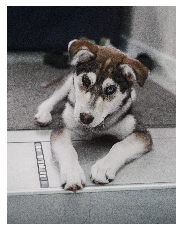

In [9]:
# create function to process inference results
def processAndDisplayResults(probs, orig_input_image, orig_input_path):
    # display image
    plt.figure()
    plt.axis("off")
    im_to_show = cv2.cvtColor(orig_input_image, cv2.COLOR_BGR2RGB)

    # report top n results for image
    print("Top ", report_top_n, " results for image",orig_input_path,":")
    
    # remove dimensions of length=1
    probs = np.squeeze(probs)
    
    # sort then return top report_top_n entries
    top_ind = np.argsort(probs)[-report_top_n:][::-1]
    
    # show input image
    plt.imshow(im_to_show)
    
    # print out top probabilities, looking up label
    print("Probability% is <label>")
    for id in top_ind:
        det_label = labels_map[id] if labels_map else "#{}".format(id)
        print(" {:.7f} % is {}".format(probs[id], det_label))
    print("\n")

processAndDisplayResults(res[output_blob][0], image, input_path)
print("Processed and displayed inference output results.")

## Exercise #1: Run a different image

Now that we have seen all the steps, let us run them again on a different image.  We also define `inferImage()` to combine the input processing, inference, and processing and displaying results so that we may use it again later in the tutorial.

Loaded input image [ cat.jpg ], resolution= 4484.0 w x  2989.0 h
Resized input image from (2989, 4484) to (227, 227)
Top  10  results for image cat.jpg :
Probability% is <label>
 0.7960738 % is tabby cat
 0.0751250 % is catamount
 0.0719629 % is cat
 0.0560304 % is cat
 0.0004140 % is Panthera tigris
 0.0000951 % is bathing tub, bath, tub
 0.0000372 % is triceratops
 0.0000265 % is vat
 0.0000255 % is shepherd, German shepherd dog, German police dog, alsatian
 0.0000253 % is terrier




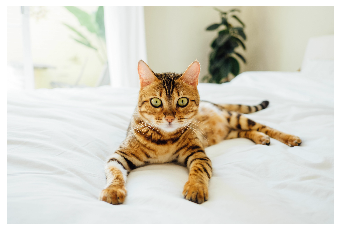

In [10]:
# define function to prepare input, run inference, and process inference results
def inferImage(image, input_path):
    # prepare input
    in_frame = resizeInputImage(image)

    # run inference
    res = exec_net.infer(inputs={input_blob: in_frame})   

    # process inference results 
    processAndDisplayResults(res[output_blob][0], image, input_path)

# set path to different input image
input_path="cat.jpg"

# load input image
image = loadInputImage(input_path)

# infer image and display results
inferImage(image, input_path)

## Exercise #2: (Optional) Run your own image

Here you may run any image you would like by setting the `input_path` variable which may be set to a local file or URL.  A sample URL is provided as an example.

Loaded input image [ https://cdn.pixabay.com/photo/2015/06/25/12/27/daisy-821222_1280.jpg ], resolution= 1280.0 w x  847.0 h
Resized input image from (847, 1280) to (227, 227)
Top  10  results for image https://cdn.pixabay.com/photo/2015/06/25/12/27/daisy-821222_1280.jpg :
Probability% is <label>
 0.9985966 % is daisy
 0.0008350 % is bee
 0.0005569 % is fly
 0.0000037 % is earthstar
 0.0000036 % is ringlet butterfly
 0.0000014 % is emmet, pismire
 0.0000006 % is beetle, chrysomelid
 0.0000005 % is acorn
 0.0000005 % is honeycomb
 0.0000004 % is butterfly, sulfur butterfly




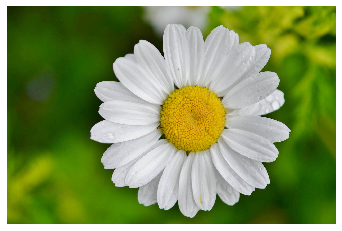

In [11]:
# input_path may be set to a local file or URL
input_path = "https://cdn.pixabay.com/photo/2015/06/25/12/27/daisy-821222_1280.jpg"

# load input image
image = loadInputImage(input_path)

# infer image and display results
inferImage(image, input_path)

## Inferring input images in batches

We have seen how to run inference on a single input image, we will now see how to infer multiple input images in batches.  Inferring in batches follows the same steps as when inferring a single input image, including using a single call to perform inference, except that an array (batch) of inputs must be prepared and an array (batch) of outputs must be processed.

### Preparing a batch of inputs

Preparing a batch of input images is much like when preparing a single image except that the input to inference is now an array of inputs stored in `batch_paths`.  Running multiple input images also means that arrays (`orig_image_paths` and `orig_images`) are needed to store input data to be used later.

In [12]:
# batch of inputs which may be local files or URLs (comma separated)
batch_paths = ["./dog.jpg", "./cat.jpg", "./bird.jpg"]

# define function to load input images into input batch
def batchLoadInputImages(batch_paths):
    global batch_size
    global batch_images
    global orig_image_paths
    global orig_images
    batch_size = len(batch_paths)

    # create input batch (array) of input images 
    batch_images = np.ndarray(shape=(batch_size, c, h, w))

    # create array to hold original images and paths for displaying later
    orig_images = []
    orig_image_paths = []

    for i in range(batch_size):
        # load image
        image = loadInputImage(batch_paths[i])

        # save original image and path
        orig_images.append(image)
        orig_image_paths.append(batch_paths[i])

        # prepare input
        in_frame = resizeInputImage(image)

        # add input to batch
        batch_images[i] = in_frame
    return batch_size, batch_images, orig_image_paths, orig_images

batchLoadInputImages(batch_paths)
print("Loaded", batch_size, "images.")

Loaded input image [ ./dog.jpg ], resolution= 3124.0 w x  4020.0 h
Resized input image from (4020, 3124) to (227, 227)
Loaded input image [ ./cat.jpg ], resolution= 4484.0 w x  2989.0 h
Resized input image from (2989, 4484) to (227, 227)
Loaded input image [ ./bird.jpg ], resolution= 3264.0 w x  2448.0 h
Resized input image from (2448, 3264) to (227, 227)
Loaded 3 images.


### Running inference on a batch of inputs

To process all the input images, the inference model needs to know how large the input array (batch) is.  Batch size is set using `<IENetwork>.batch_size = <n>`.  This will change the batch size of the network before it has been loaded into the Inference Engine.  To get the change to take effect, we must reload the network into the plugin before running inference.

Inference will be run on the previous setting of `batch_paths` for the three images `./dog.jpg`, `./cat.jpg`, and `./bird.jpg"`:
<div><img src="dog.jpg" style="height:150px; display: inline-block"/>
<img src="cat.jpg" style="height:150px; display: inline-block"/>
<img src="bird.jpg" style="height:150px; display: inline-block"/></div>

In [13]:
# set the batch size to match the number of input images
net.batch_size = batch_size
print("Network batch size set to", batch_size)

## reload network because batch size has changed 
exec_net = ie.load_network(network=net, num_requests=2, device_name=device)


# save start time
inf_start = time.time()

# run inference
res = exec_net.infer(inputs={input_blob: batch_images})   

# calculate time from start until now
inf_time = time.time() - inf_start
print("Inference complete, run time: {:.3f} ms".format(inf_time * 1000))

Network batch size set to 3
Inference complete, run time: 10.808 ms


### Processing and displaying a batch of outputs

Top  10  results for image ./dog.jpg :
Probability% is <label>
 0.5577507 % is husky
 0.0910857 % is malemute, Alaskan malamute
 0.0681064 % is pug-dog
 0.0621666 % is Chihuahua
 0.0462494 % is dog, husky
 0.0418669 % is cat
 0.0138482 % is ferret, ferret, Mustela nigripes
 0.0109663 % is cat
 0.0091384 % is retriever
 0.0080643 % is beagle


Top  10  results for image ./cat.jpg :
Probability% is <label>
 0.7960738 % is tabby cat
 0.0751250 % is catamount
 0.0719629 % is cat
 0.0560304 % is cat
 0.0004140 % is Panthera tigris
 0.0000951 % is bathing tub, bath, tub
 0.0000372 % is triceratops
 0.0000265 % is vat
 0.0000255 % is shepherd, German shepherd dog, German police dog, alsatian
 0.0000253 % is terrier


Top  10  results for image ./bird.jpg :
Probability% is <label>
 0.7483377 % is magpie
 0.2082348 % is mollymawk
 0.0139266 % is hammerhead shark
 0.0126793 % is goose
 0.0046393 % is egret, great white heron, Egretta albus
 0.0043396 % is whale, killer, orca, grampus, sea wolf, 

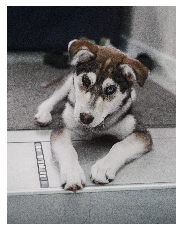

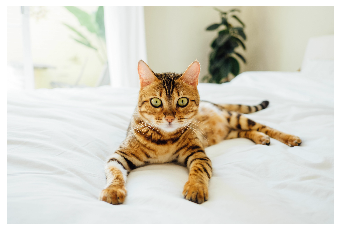

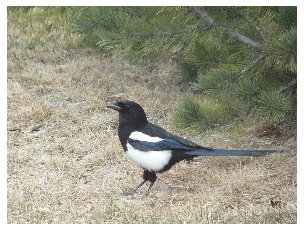

In [14]:
# create function to process inference results
def batchProcessAndDisplayResults(result, orig_input_images, orig_image_paths):
    # get output results
    res = result[output_blob]

    for i, probs in enumerate(res):
        processAndDisplayResults(probs, orig_input_images[i], orig_image_paths[i])
        
# process inference results 
batchProcessAndDisplayResults(res, orig_images, orig_image_paths)

## Exercise #3: (Optional) Run your own batch of images

Here you may run any image you would like by setting the `batch_paths` variable to an array of paths, which may be a local file or URL.  A sample array is provided as an example.

Loaded input image [ https://cdn.pixabay.com/photo/2015/06/25/12/27/daisy-821222_1280.jpg ], resolution= 1280.0 w x  847.0 h
Resized input image from (847, 1280) to (227, 227)
Loaded input image [ ./cat.jpg ], resolution= 4484.0 w x  2989.0 h
Resized input image from (2989, 4484) to (227, 227)
Loaded 2 images.
Network batch size set to 2
Top  10  results for image https://cdn.pixabay.com/photo/2015/06/25/12/27/daisy-821222_1280.jpg :
Probability% is <label>
 0.9978332 % is daisy
 0.0012564 % is bee
 0.0008917 % is fly
 0.0000077 % is ringlet butterfly
 0.0000046 % is earthstar
 0.0000018 % is emmet, pismire
 0.0000012 % is acorn
 0.0000010 % is beetle, chrysomelid
 0.0000008 % is honeycomb
 0.0000006 % is butterfly, sulfur butterfly


Top  10  results for image ./cat.jpg :
Probability% is <label>
 0.7960738 % is tabby cat
 0.0751250 % is catamount
 0.0719629 % is cat
 0.0560304 % is cat
 0.0004140 % is Panthera tigris
 0.0000951 % is bathing tub, bath, tub
 0.0000372 % is triceratops
 

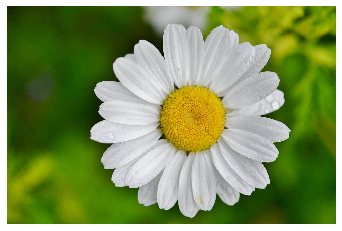

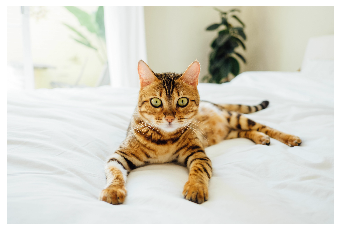

In [15]:
# batch of inputs which may be local files or URLs (comma separated)
batch_paths = [
    "https://cdn.pixabay.com/photo/2015/06/25/12/27/daisy-821222_1280.jpg",
    "./cat.jpg"]

# load batch of inputs
batchLoadInputImages(batch_paths)
print("Loaded", batch_size, "images.")

# set the batch size to match the number of input images
net.batch_size = batch_size
print("Network batch size set to", batch_size)

# reload network because batch size has changed 
exec_net = ie.load_network(network=net, num_requests=2, device_name=device)

# run inference
res = exec_net.infer(inputs={input_blob: batch_images})   

# process inference results 
batchProcessAndDisplayResults(res, orig_images, orig_image_paths)

print("Done.")

## Report performance counters
After running inference, the performance counters may be read from an internal request object using the function `get_perf_counts()` to see which layers of the inference model were run and how much time was spent in each.  Performance counts (metrics) reported include:
- **name** - Name of layer within the inference model
- **layer_type** - Type (or function) of layer (e.g. convolution, concat, etc.)
- **exec_type** - Execution type for the layer.  The name may be used to identify which device has been run.  For example, entries starting with `jit_` indicate the CPU was used.
- **status** - Whether the layer had been executed or not
- **real_time** - Time in microseconds spent running layer

In [16]:
# retrieve performance counters from last inference request
perf_counts = exec_net.requests[0].get_perf_counts()

# display performance counters for each layer
print("Performance counters:")
print("{:<40} {:<15} {:<15} {:<15} {:<10}".format('name', 'layer_type', 
        'exec_type', 'status', 'real_time, us'))
for layer, stats in perf_counts.items():
    print("{:<40} {:<15} {:<15} {:<15} {:<10}".format(layer,
        stats['layer_type'], stats['exec_type'],
        stats['status'], stats['real_time']))

Performance counters:
name                                     layer_type      exec_type       status          real_time, us
conv1                                    Convolution     jit_avx2_FP32   EXECUTED        740       
conv10                                   Convolution     jit_avx2_1x1_FP32 EXECUTED        941       
fire2/concat                             Concat          unknown_FP32    EXECUTED        2         
fire2/expand1x1                          Convolution     jit_avx2_1x1_FP32 EXECUTED        37        
fire2/expand3x3                          Convolution     jit_avx2_FP32   EXECUTED        238       
fire2/relu_expand1x1                     ReLU            undef           NOT_RUN         0         
fire2/relu_expand3x3                     ReLU            undef           NOT_RUN         0         
fire2/relu_squeeze1x1                    ReLU            undef           NOT_RUN         0         
fire2/squeeze1x1                         Convolution     jit_avx2_1x1_F

## Cleanup

Now that we are done running the sample, we clean up by deleting objects before exiting.

In [17]:
del exec_net
del net
del ie

print("Resource objects removed")

Resource objects removed


## Next steps

- [More Jupyter Notebook Tutorials](../README.md) - additional sample application Jupyter* Notebook tutorials
- [Intel® Distribution of OpenVINO™ toolkit Main Page](https://software.intel.com/openvino-toolkit) - learn more about the tools and use of the Intel® Distribution of OpenVINO™ toolkit for implementing inference on the edge

## About this notebook

For technical support, please see:
* [Intel® Computer Vision Forum](https://software.intel.com/en-us/forums/computer-vision)

<p style=background-color:#0071C5;color:white;padding:0.5em;display:table-cell;width:100pc;vertical-align:middle>
<img style=float:right src="https://software.intel.com/etc.clientlibs/settings/wcm/designs/intel/clientlibs/pages/commons-page/resources/images/intel-logo-highres.png" alt="Intel logo" width="75px"/>
<a style=color:white>Intel® Distribution of OpenVINO™ toolkit</a><br>   
<a style=color:white href="#top">Top of Page&#8593</a> 
</p>
